In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset
import kagglehub
from diffusers import UNet2DModel, DDPMScheduler
import numpy as np

In [119]:
IMG_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Crop center to remove background
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
torch.manual_seed(42)
# indices = torch.randperm(162770)[:80000] # 80k subset of training image indices
indices = torch.randperm(162770)[:10000] # 80k subset of training image indices

dataset = datasets.ImageFolder(root=path, transform=transform)
dataset = Subset(dataset, indices)  # Create subset of dataset



cuda


In [120]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 2e-5
TOTAL_TIMESTEPS=1000

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [153]:
# Define the UNet model
diffusion_model = UNet2DModel(
    sample_size=128,  
    in_channels=3,  
    out_channels=3,  
    layers_per_block=2,  
    block_out_channels=[64, 128, 256, 512, 512],  
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "AttnUpBlock2D", "UpBlock2D")
).to(device)

# Diffusion scheduler (Using cosine beta schedule)
betas = np.linspace(1e-5, 1e-2, TOTAL_TIMESTEPS, dtype=np.float32)  
scheduler = DDPMScheduler(
    num_train_timesteps=TOTAL_TIMESTEPS,
    trained_betas=torch.tensor(betas, dtype=torch.float32, device=device)
)
# Optimizer with Cosine Annealing LR Scheduler
optimizer = optim.AdamW(diffusion_model.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


/home/rajiv/miniconda3/envs/mlenv/lib/python3.12/site-packages/diffusers/schedulers/scheduling_ddpm.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


default train

In [50]:
# import torch.nn.functional as F
# from tqdm import tqdm

# for epoch in range(EPOCHS):
#     diffusion_model.train()
#     epoch_loss = 0
#     progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

#     for images, _ in progress_bar:
#         images = images.to(device)

#         # Sample noise
#         noise = torch.randn_like(images).to(device)
#         timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device=device).long()

#         # Forward pass (diffusion step)
#         noisy_images = scheduler.add_noise(images, noise, timesteps)
#         noise_pred = diffusion_model(noisy_images, timesteps).sample

#         # Compute loss (MSE)
#         loss = F.mse_loss(noise_pred, noise)
#         epoch_loss += loss.item()

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         progress_bar.set_postfix(loss=loss.item())

#     print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss / len(dataloader):.4f}")

#     # Save checkpoint every 10 epochs
#     if (epoch + 1) % 2 == 0:
#         torch.save(diffusion_model.state_dict(), f"checkpoints/diffusion_celeba_epoch{epoch+1}.pth")


In [51]:
# import time
# start_time = time.time()
# for images, _ in dataloader:
#     pass
# print(f"Time per batch (CPU → GPU): {(time.time() - start_time) / len(dataloader):.4f}s")

with inference

In [ ]:
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to generate and display images
def generate_images(model, scheduler, epoch, num_images=4, img_size=128):
    model.eval()
    with torch.no_grad():
        generated_images = torch.randn((num_images, 3, img_size, img_size), device=device)

        for t in reversed(range(scheduler.config.num_train_timesteps)):
            timesteps = torch.full((num_images,), t, device=device, dtype=torch.long)
            with torch.autocast(device_type="cuda", dtype=torch.float16):  # AMP enabled
                noise_pred = model(generated_images, timesteps).sample
                generated_images = scheduler.step(noise_pred, t, generated_images).prev_sample

        # Denormalize images
        generated_images = (generated_images.clamp(-1, 1) + 1) / 2  

        # Show the generated images
        grid = vutils.make_grid(generated_images, nrow=2)  # 2x2 grid
        plt.figure(figsize=(6, 6))
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()

# Training function (No GradScaler)
def train_diffusion(model, dataloader, scheduler, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", mininterval=2.0)  

        for images, _ in progress_bar:
            images = images.to(device)
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device=device).long()

            optimizer.zero_grad()
            with torch.autocast(device_type="cuda", dtype=torch.float16):  # AMP enabled
                noisy_images = scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss / len(dataloader):.4f}")

        # Save model checkpoint every 2 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"checkpoints/diffusion_celeba_epoch{epoch+1}.pth")

            # Run inference after each epoch (display only 4 images)
            generate_images(model, scheduler, epoch)

# Call training function
train_diffusion(diffusion_model, dataloader, scheduler, optimizer, EPOCHS)


Epoch 1/50:  13%|█▎        | 40/313 [00:16<01:51,  2.44it/s, loss=0.522]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004164219..0.986241].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48023307..1.2838297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8864467..1.5885872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.195901..1.8363956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4027387..2.0623155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.51911..2.2065282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5684493

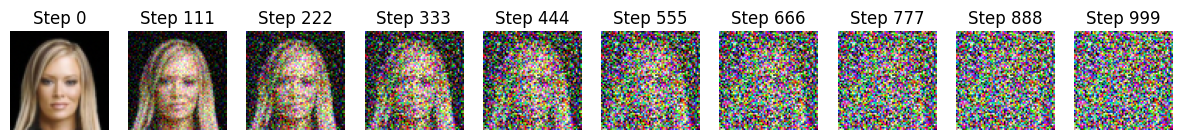

In [155]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show_forward_diffusion(image, scheduler, num_steps=10):
    """Visualize the forward diffusion process on a single image."""
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    noise = torch.randn_like(image)  # Sample a single noise tensor
    
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 5))
    
    # Show original image
    # axes[0].imshow((image.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2)
    # axes[0].set_title("Original Image")
    # axes[0].axis("off")

    # Apply noise step by step
    for i, step in enumerate(torch.linspace(0, scheduler.config.num_train_timesteps - 1, num_steps).long()):
        noisy_image = scheduler.add_noise(image, noise, step.to(device))
        axes[i ].imshow((noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2)
        axes[i ].set_title(f"Step {step.item()}")
        axes[i ].axis("off")

    plt.show()

# Get a single image from the dataloader
example_image, _ = next(iter(dataloader))

# Show the forward diffusion process
show_forward_diffusion(example_image[0], scheduler, num_steps=10)


In [ ]:
generate_images(diffusion_model, scheduler, 0)

In [ ]:
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# # Load model if resuming inference
# diffusion_model.load_state_dict(torch.load("diffusion_celeba_epoch100.pth", map_location=device))
# diffusion_model.eval()

# # Generate images
# num_images = 16  # Number of images to generate
# generated_images = torch.randn((num_images, 3, 128, 128), device=device)

# # Reverse diffusion process
# for t in tqdm(reversed(range(scheduler.config.num_train_timesteps)), desc="Generating images"):
#     timesteps = torch.full((num_images,), t, device=device, dtype=torch.long)
#     with torch.no_grad():
#         noise_pred = diffusion_model(generated_images, timesteps).sample
#     generated_images = scheduler.step(noise_pred, t, generated_images).prev_sample

# # Denormalize and visualize
# generated_images = (generated_images.clamp(-1, 1) + 1) / 2  # Scale back to [0,1]
# grid = vutils.make_grid(generated_images, nrow=4)

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# plt.show()
